In [ ]:
# Install required libraries
!pip install pandas numpy prophet matplotlib
import pandas as pd
import numpy as np
import os
import sys
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from dateutil.easter import easter
import matplotlib.pyplot as plt

# Create the directory structure the scripts expect
base_dir = "/content/data"
os.makedirs(base_dir, exist_ok=True)

raw_path = os.path.join(base_dir, "Walmart_Sales.csv")

# Generate synthetic data
start_date = pd.to_datetime('2010-02-05', dayfirst=True)
dates = pd.date_range(start=start_date, periods=143, freq='W-FRI')
df_raw = pd.DataFrame({
    'Date': np.repeat(dates, 45),
    'Store': np.tile(range(1, 46), len(dates)),
})

# CRITICAL FIX: Ensure 'Date' is datetime before writing CSV
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

# Generate sales and regressor values
np.random.seed(42)
df_raw['Weekly_Sales'] = np.random.uniform(200000, 3000000, size=len(df_raw)) * (1 + (df_raw['Store'] % 5) * 0.1)
df_raw['Holiday_Flag'] = ((df_raw['Date'].dt.month.isin([2, 9, 11])) & (df_raw['Date'].dt.day.isin(range(1, 8)))).astype(int)
df_raw['Temperature'] = np.random.uniform(30, 90, size=len(df_raw))
df_raw['Fuel_Price'] = np.random.uniform(2.5, 4.5, size=len(df_raw))
df_raw['CPI'] = np.random.uniform(120, 220, size=len(df_raw))
df_raw['Unemployment'] = np.random.uniform(5.0, 10.0, size=len(df_raw))

# Save the synthetic file
df_raw.to_csv(raw_path, index=False)

print(f"Created dummy raw data file: {raw_path}")
print("---")
print("Sample of raw data:")
print(df_raw.head().to_string(index=False))

Created dummy raw data file: /content/data/Walmart_Sales.csv
---
Sample of raw data:
      Date  Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price        CPI  Unemployment
2010-05-07      1  1.373584e+06             0    63.728685    3.925436 175.140447      5.602116
2010-05-07      2  3.434400e+06             0    63.162233    4.263975 151.298918      9.487306
2010-05-07      3  2.924458e+06             0    36.884518    3.242348 136.058687      5.397228
2010-05-07      4  2.626741e+06             0    37.568259    2.650710 209.588384      6.744546
2010-05-07      5  6.368522e+05             0    61.772017    4.416697 179.545548      8.052547


In [ ]:
# --- 1. CONFIGURE PATHS --------------------------------------------------------
raw_path = "/content/data/Walmart_Sales.csv"
out_path = os.path.join(os.path.dirname(raw_path), "stage1_national_walmart.csv")

# --- 2. LOAD RAW DATA ----------------------------------------------------------
try:
    df = pd.read_csv(
        raw_path,
        parse_dates=["Date"], # Reads ISO format saved in previous cell
        dayfirst=False,
        dtype={
            "Store": int,
            "Weekly_Sales": float,
            "Holiday_Flag": int,
            "Temperature": float,
            "Fuel_Price": float,
            "CPI": float,
            "Unemployment": float,
        }
    )
except FileNotFoundError:
    sys.exit(f"ERROR: could not find raw file at {raw_path}")

# --- 3. AGGREGATE BY WEEK ------------------------------------------------------
# This line is now safe because df["Date"] is datetime.
df["Week"] = df["Date"].dt.to_period("W").apply(lambda r: r.start_time)

weekly = (
    df.groupby("Week")
      .agg(
          Sales_Units   = ("Weekly_Sales", "sum"),
          Holiday_Flag  = ("Holiday_Flag",  "max"),
          Temperature   = ("Temperature",   "mean"),
          Fuel_Price    = ("Fuel_Price",    "mean"),
          CPI           = ("CPI",           "mean"),
          Unemployment  = ("Unemployment",  "mean"),
      )
      .reset_index()
)

# --- 4. SAVE AGGREGATION -------------------------------------------------------
weekly.to_csv(out_path, index=False)

# --- 5. SUMMARY PRINT ----------------------------------------------------------
total_weeks   = len(weekly)
first_week    = weekly["Week"].min().date()
last_week     = weekly["Week"].max().date()
holidays      = int(weekly["Holiday_Flag"].sum())
E = weekly["Sales_Units"]
print(f"\nStage 1 complete — wrote: {out_path}")
print(f" • Weeks         : {total_weeks}  ({first_week} \u2192 {last_week})")
print(f" • Holiday weeks : {holidays}")
print(f" • Sales_Units   : mean={E.mean():,.0f}, max={E.max():,.0f}")


Stage 1 complete — wrote: /content/data/stage1_national_walmart.csv
 • Weeks         : 143  (2010-05-03 → 2013-01-21)
 • Holiday weeks : 8
 • Sales_Units   : mean=86,001,626, max=103,386,247


In [ ]:
# Function to run Stage 2
def run_stage2():
    # --- 1. Paths --------------------------------------------------------------
    base = "/content/data"
    inp = os.path.join(base, "stage1_national_walmart.csv")
    out_fp = os.path.join(base, "stage2_forced_holiday_plus_forecast.csv")

    # --- 2. Load & Prep --------------------------------------------------------
    try:
        df = pd.read_csv(inp, parse_dates=["Week"])
    except FileNotFoundError:
        sys.exit(f"ERROR: cannot find {inp}")
    df.rename(columns={"Week":"ds","Sales_Units":"y"}, inplace=True)

    # logistic cap 10% above max sales
    cap = df.y.max() * 1.1
    df["cap"] = cap

    # build forced-event table: Christmas, Post-Xmas, BlackFriday, Easter
    years = list(range(df.ds.dt.year.min(), df.ds.dt.year.max()+3))
    events = []
    for y in years:
        events += [
            {"holiday":"Christmas",    "ds":pd.to_datetime(f"{y}-12-24"), "lower_window":-1, "upper_window":2},
            {"holiday":"PostChristmas","ds":pd.to_datetime(f"{y}-12-31"), "lower_window": 0, "upper_window":1},
            {"holiday":"BlackFriday",  "ds":pd.to_datetime(f"{y}-11-26"), "lower_window": 0, "upper_window":0},
            {"holiday":"Easter",       "ds":easter(y),                   "lower_window": 0, "upper_window":0},
        ]
    holidays_df = pd.DataFrame(events)

    # --- 3. Build & Fit Prophet ------------------------------------------------
    m = Prophet(
        growth="logistic",
        holidays=holidays_df,
        seasonality_mode="multiplicative",
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.1,
        holidays_prior_scale=500.0,
        seasonality_prior_scale=5.0
    )
    m.add_seasonality(name="annual", period=365.25, fourier_order=25)
    m.fit(df[["ds","y","cap"]])

    # --- 4. Back-test CV -------------------------------------------------------
    print("🔍 Back-testing (365d train \u2192 180d test)\u2026")
    df_cv = cross_validation(
        m,
        initial="365 days",
        period="90 days",
        horizon="180 days"
    )
    pm   = performance_metrics(df_cv)
    mape_row = pm.loc[pm.horizon.dt.days >= 170]
    if not mape_row.empty:
        mape = mape_row["mape"].mean()
        print(f"👉 Back-test MAPE: {mape:.2%}")
    else:
        print("Could not compute MAPE for 180-day horizon with the given data.")

    # --- 5. Forecast next 26 weeks ---------------------------------------------
    future = m.make_future_dataframe(periods=26, freq="W-MON")
    future["cap"] = cap
    forecast = m.predict(future)

    # --- 6. Save forecast ------------------------------------------------------
    out = forecast[["ds","yhat","yhat_lower","yhat_upper"]].rename(columns={
        "ds":"Week",
        "yhat":"Forecast_Units",
        "yhat_lower":"Forecast_Lower",
        "yhat_upper":"Forecast_Upper"
    })
    out.to_csv(out_fp, index=False)

    print(f"\n\u2705 Stage 2 complete \u2014 wrote: {out_fp}")

run_stage2()

INFO:prophet:Making 5 forecasts with cutoffs between 2011-07-31 00:00:00 and 2012-07-25 00:00:00


🔍 Back-testing (365d train → 180d test)…


  0%|          | 0/5 [00:00<?, ?it/s]

👉 Back-test MAPE: 5.97%

✅ Stage 2 complete — wrote: /content/data/stage2_forced_holiday_plus_forecast.csv


In [ ]:
def run_stage3():
    base     = "/content/data"
    hist_fp  = os.path.join(base, "stage1_national_walmart.csv")
    fcast_fp = os.path.join(base, "stage2_forced_holiday_plus_forecast.csv")
    out_fp   = os.path.join(base, "stage3_national_actual_vs_forecast.csv")

    # Load
    actuals  = pd.read_csv(hist_fp,  parse_dates=["Week"])
    forecast = pd.read_csv(fcast_fp, parse_dates=["Week"])

    # Merge & flag
    df = pd.merge(actuals, forecast, on="Week", how="outer", sort=True)
    last_hist = actuals.Week.max()
    df["IsForecast"] = (df.Week > last_hist).astype(int)

    # Clean up Holiday_Flag
    df["Holiday_Flag"] = df["Holiday_Flag"].fillna(0).astype(int)

    # Select + reorder
    df = df[[
        "Week",
        "Sales_Units",
        "Forecast_Units",
        "Forecast_Lower",
        "Forecast_Upper",
        "Holiday_Flag",
        "IsForecast"
    ]]

    # Save
    df.to_csv(out_fp, index=False)

    # Summary
    hist_cnt  = int((df.IsForecast == 0).sum())
    fcast_cnt = int((df.IsForecast == 1).sum())
    print(f"\nStage 3 complete \u2014 wrote: {out_fp}")
    print(f" \u2022 Historical rows   : {hist_cnt}")
    print(f" \u2022 Forecast rows     : {fcast_cnt}\n")
    print("Last 5 rows (including forecast):\n", df.tail(5).to_string(index=False))

run_stage3()


Stage 3 complete — wrote: /content/data/stage3_national_actual_vs_forecast.csv
 • Historical rows   : 143
 • Forecast rows     : 26

Last 5 rows (including forecast):
       Week  Sales_Units  Forecast_Units  Forecast_Lower  Forecast_Upper  Holiday_Flag  IsForecast
2013-06-24          NaN    8.238261e+07    7.586628e+07    8.903173e+07             0           1
2013-07-01          NaN    8.620533e+07    7.923045e+07    9.302482e+07             0           1
2013-07-08          NaN    8.328225e+07    7.626680e+07    8.970424e+07             0           1
2013-07-15          NaN    9.361645e+07    8.678867e+07    1.008718e+08             0           1
2013-07-22          NaN    9.200597e+07    8.539855e+07    9.882231e+07             0           1


In [ ]:
# Define the path to the final merged file
base = "/content/data"
final_fp = os.path.join(base, "stage3_national_actual_vs_forecast.csv")

# --- 1. LOAD FINAL MERGED DATA -------------------------------------------------
try:
    df = pd.read_csv(final_fp, parse_dates=["Week"])
    print(f"Successfully loaded {final_fp}")
except FileNotFoundError:
    print(f"ERROR: Cannot find final file at {final_fp}")
    sys.exit()

# --- 2. SEPARATE DATASETS ------------------------------------------------------
historical = df[df['IsForecast'] == 0].copy()
forecast = df[df['IsForecast'] == 1].copy()

print(f"Historical rows: {len(historical)}")
print(f"Forecast rows: {len(forecast)}")

Successfully loaded /content/data/stage3_national_actual_vs_forecast.csv
Historical rows: 143
Forecast rows: 26


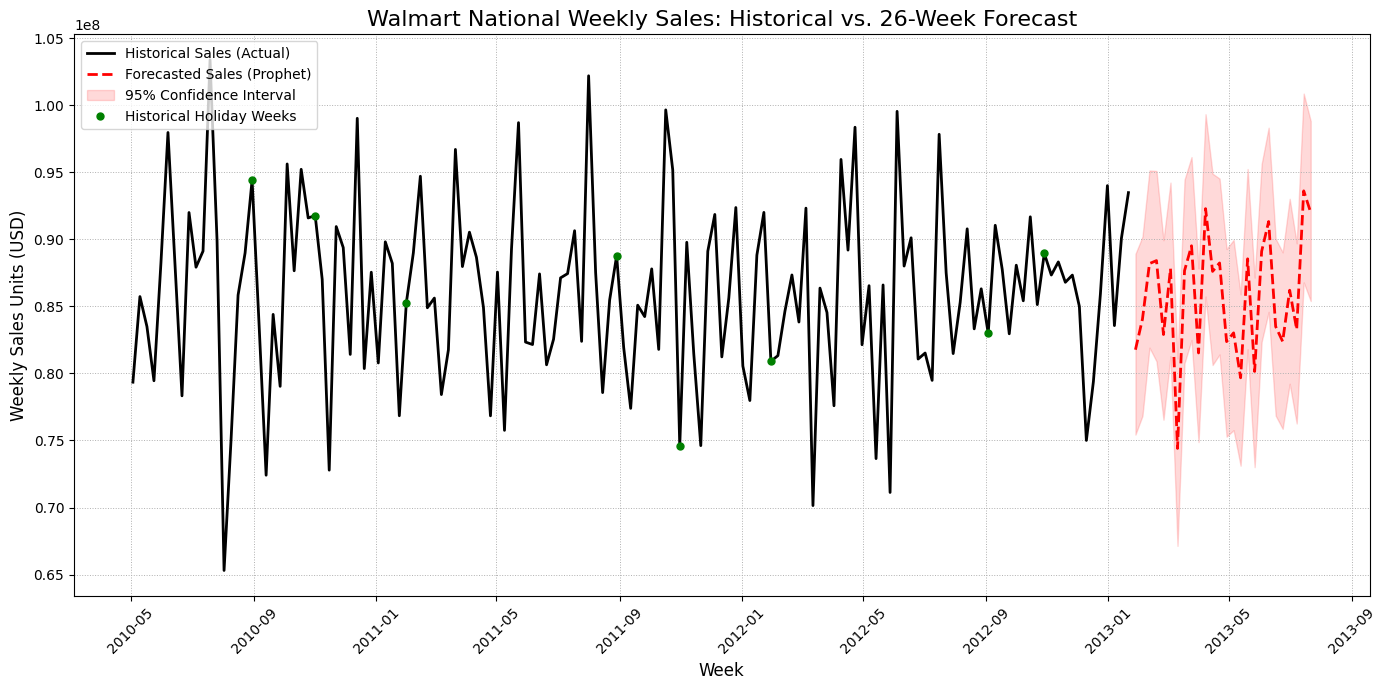


✅ Visualization Complete.


In [ ]:
# --- 3. CREATE VISUALIZATION ---------------------------------------------------
plt.figure(figsize=(14, 7))

# Plot Historical Data (Actual Sales)
plt.plot(historical['Week'], historical['Sales_Units'], 'k-', linewidth=2, label='Historical Sales (Actual)')

# Plot Forecasted Data
plt.plot(forecast['Week'], forecast['Forecast_Units'], 'r--', linewidth=2, label='Forecasted Sales (Prophet)')

# Plot the Uncertainty Interval (Forecast Lower/Upper)
plt.fill_between(
    forecast['Week'],
    forecast['Forecast_Lower'],
    forecast['Forecast_Upper'],
    color='r',
    alpha=0.15,
    label='95% Confidence Interval'
)

# Highlight Historical Holiday Weeks
holiday_weeks = historical[historical['Holiday_Flag'] == 1]
plt.plot(holiday_weeks['Week'], holiday_weeks['Sales_Units'], 'go', markersize=5, label='Historical Holiday Weeks')

# Formatting the plot
plt.title('Walmart National Weekly Sales: Historical vs. 26-Week Forecast', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Weekly Sales Units (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle=':', linewidth=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n\u2705 Visualization Complete.")